# MST tutorial

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline  

In [12]:
def mst(scores):
    """
    Chu-Liu-Edmonds' algorithm for finding minimum spanning arborescence in graphs.
    Calculates the arborescence with node 0 as root.
    Source: https://github.com/chantera/biaffineparser/blob/master/utils.py
    
    WARNING: mind the comment below. This mst function expects scores[i][j] to be the score from j to i, 
    not from i to j (as you would probably expect!). If you use a graph where you have the convention
    that a head points to its dependent, you will need to transpose it before calling this function.
    That is, call `mst(scores.T)` instead of `mst(scores)`.

    :param scores: `scores[i][j]` is the weight of edge from node `j` to node `i`
    :returns an array containing the head node (node with edge pointing to current node) for each node,
             with head[0] fixed as 0
    """
    length = scores.shape[0]
    scores = scores * (1 - np.eye(length))
    heads = np.argmax(scores, axis=1)
    heads[0] = 0
    tokens = np.arange(1, length)
    roots = np.where(heads[tokens] == 0)[0] + 1
    
    # print initial heads
    print("initial heads:", heads)
    
    # deal with roots
    if len(roots) < 1:
        print("no node is pointing to root, choosing one")
        root_scores = scores[tokens, 0]
        head_scores = scores[tokens, heads[tokens]]
        new_root = tokens[np.argmax(root_scores / head_scores)]
        print("new root is:", new_root)
        heads[new_root] = 0
    elif len(roots) > 1:
        print("multiple nodes are pointing to root, choosing one")
        root_scores = scores[roots, 0]
        scores[roots, 0] = 0
        new_heads = np.argmax(scores[roots][:, tokens], axis=1) + 1
        new_root = roots[np.argmin(scores[roots, new_heads] / root_scores)]
        print("new root is:", new_root)
        heads[roots] = new_heads
        heads[new_root] = 0

    # construct edges and vertices
    edges = defaultdict(set)
    vertices = set((0,))
    for dep, head in enumerate(heads[tokens]):
        vertices.add(dep + 1)
        edges[head].add(dep + 1)
        
    # identify cycles & contract
    for cycle in _find_cycle(vertices, edges):
        print("Found cycle!", cycle)
        dependents = set()
        to_visit = set(cycle)
        while len(to_visit) > 0:
            node = to_visit.pop()
            print("Contraction, visiting node:", node)
            if node not in dependents:
                dependents.add(node)
                to_visit.update(edges[node])
        cycle = np.array(list(cycle))
        old_heads = heads[cycle]
        old_scores = scores[cycle, old_heads]
        non_heads = np.array(list(dependents))
        scores[np.repeat(cycle, len(non_heads)),
               np.repeat([non_heads], len(cycle), axis=0).flatten()] = 0
        new_heads = np.argmax(scores[cycle][:, tokens], axis=1) + 1
        new_scores = scores[cycle, new_heads] / old_scores
        change = np.argmax(new_scores)
        changed_cycle = cycle[change]
        old_head = old_heads[change]
        new_head = new_heads[change]
        heads[changed_cycle] = new_head
        edges[new_head].add(changed_cycle)
        edges[old_head].remove(changed_cycle)

    return heads

In [3]:
def _find_cycle(vertices, edges):
    """
    Finds cycles in given graph, where the graph is provided as (vertices, edges).
    https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm  # NOQA
    https://github.com/tdozat/Parser/blob/0739216129cd39d69997d28cbc4133b360ea3934/lib/etc/tarjan.py  # NOQA
    """
    _index = [0]
    _stack = []
    _indices = {}
    _lowlinks = {}
    _onstack = defaultdict(lambda: False)
    _SCCs = []

    def _strongconnect(v):
        _indices[v] = _index[0]
        _lowlinks[v] = _index[0]
        _index[0] += 1
        _stack.append(v)
        _onstack[v] = True

        for w in edges[v]:
            if w not in _indices:
                _strongconnect(w)
                _lowlinks[v] = min(_lowlinks[v], _lowlinks[w])
            elif _onstack[w]:
                _lowlinks[v] = min(_lowlinks[v], _indices[w])

        if _lowlinks[v] == _indices[v]:
            SCC = set()
            while True:
                w = _stack.pop()
                _onstack[w] = False
                SCC.add(w)
                if not (w != v):
                    break
            _SCCs.append(SCC)

    for v in vertices:
        if v not in _indices:
            _strongconnect(v)

    return [SCC for SCC in _SCCs if len(SCC) > 1]

## Example 1: a short sentence

Let's try it out on the example in McDonald et al. (2005): "John saw Mary."

In [4]:
w2i = defaultdict(lambda: len(w2i))
sentence = "root john saw mary".split()
sentence_ids = [w2i[token] for token in sentence]
num_words = len(sentence)
i2w = {i: w for w, i in w2i.items()}

print(sentence)
print(sentence_ids)
print(num_words)

['root', 'john', 'saw', 'mary']
[0, 1, 2, 3]
4


In [5]:
# define the scores
scores = np.full([num_words, num_words], -1.)
scores[w2i['root']][w2i['saw']] = 10.
scores[w2i['root']][w2i['mary']] = 9.
scores[w2i['root']][w2i['john']] = 9.
scores[w2i['john']][w2i['saw']] = 20.
scores[w2i['john']][w2i['mary']] = 3.
scores[w2i['saw']][w2i['mary']] = 30.
scores[w2i['saw']][w2i['john']] = 30.
scores[w2i['mary']][w2i['john']] = 11.
scores[w2i['mary']][w2i['saw']] = 0.

print(scores)

[[ -1.   9.  10.   9.]
 [ -1.  -1.  20.   3.]
 [ -1.  30.  -1.  30.]
 [ -1.  11.   0.  -1.]]


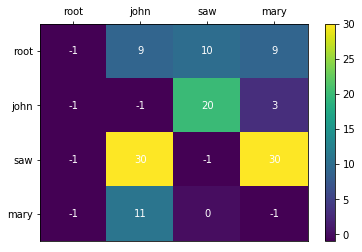

In [6]:
def plot_heatmap(scores):

    # make heatmap with the scores
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    # set tick labels to the words
    ax.set_xticklabels(sentence, minor=False)
    ax.set_yticklabels(sentence, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    # display values
    for y in range(scores.shape[0]):
        for x in range(scores.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.0f' % scores[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='w')

    plt.colorbar(heatmap)
    plt.show()
    
plot_heatmap(scores)

In [7]:
heads = mst(scores.T)
print("final heads:", heads)

initial heads: [0 2 1 2]
no node is pointing to root, choosing one
new root is: 2
final heads: [0 2 0 2]


## Example 2: a longer sentence

Let's now try this on a longer sentence.

In [8]:
# define a dummy sentence
w2i = defaultdict(lambda: len(w2i))
sentence = np.arange(10)
sentence_ids = sentence
num_words = len(sentence)
i2w = {i: w for w, i in w2i.items()}

print(sentence)
print(sentence_ids)
print(num_words)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
10


In [9]:
# define the scores
np.random.seed(seed=42)
scores = 100 * np.random.rand(num_words, num_words)
print(scores)

[[ 37.45401188  95.07143064  73.19939418  59.86584842  15.60186404
   15.59945203   5.80836122  86.61761458  60.11150117  70.80725778]
 [  2.05844943  96.99098522  83.24426408  21.23391107  18.18249672
   18.34045099  30.4242243   52.47564316  43.19450186  29.12291402]
 [ 61.18528947  13.94938607  29.21446485  36.63618433  45.60699842
   78.51759614  19.96737822  51.42344384  59.24145689   4.64504127]
 [ 60.75448519  17.05241237   6.5051593   94.88855373  96.56320331
   80.83973481  30.46137692   9.7672114   68.42330265  44.01524937]
 [ 12.20382348  49.51769101   3.43885211  90.93204021  25.87799816
   66.25222844  31.17110761  52.00680212  54.67102793  18.48544555]
 [ 96.95846278  77.51328234  93.94989416  89.48273504  59.78999788
   92.1874235    8.84925021  19.59828624   4.52272889  32.53303308]
 [ 38.86772897  27.13490318  82.87375092  35.67533267  28.09345097
   54.26960832  14.0924225   80.21969808   7.45506437  98.68869366]
 [ 77.22447693  19.87156815   0.55221171  81.54614285  

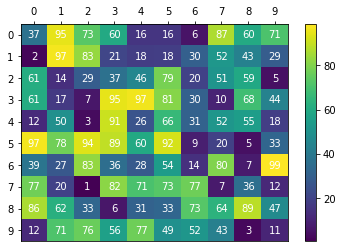

In [10]:
plot_heatmap(scores)

In [13]:
heads = mst(scores.T)
print("final heads:", heads)

initial heads: [0 0 5 4 3 3 7 0 3 6]
multiple nodes are pointing to root, choosing one
new root is: 1
Found cycle! {3, 4}
Contraction, visiting node: 3
Contraction, visiting node: 4
Contraction, visiting node: 5
Contraction, visiting node: 8
Contraction, visiting node: 2
Contraction, visiting node: 3
Found cycle! {6, 7}
Contraction, visiting node: 6
Contraction, visiting node: 7
Contraction, visiting node: 9
Contraction, visiting node: 3
Contraction, visiting node: 4
Contraction, visiting node: 5
Contraction, visiting node: 6
Contraction, visiting node: 8
Contraction, visiting node: 2
final heads: [0 0 5 7 3 3 7 1 3 6]
